# **Boston Housing Data** - *Data Analysis using PySpark*


### **Running PySpark in Google CoLab.**

To create the required setup for running PySpark:
- **Install Java**: Install Java Development Kit (JDK) version 8, which is required for running Apache Spark
- **Install Spark:** Download (`!wget -q`) and extract (`tar xf`) Apache Spark version 3.0.0 with Hadoop version 3.2
- **Set Environment Variables:** To make Spark work correctly, you need to set the JAVA_HOME and SPARK_HOME environment variables. JAVA_HOME is set to the path where Java was installed in the previous step, and SPARK_HOME is set to the path where Spark was extracted.
- **Install findspark:** '`findspark`' is a Python library that helps locate a Spark installation and makes it easier to work with Spark in a Jupyter notebook or Python script.

In [2]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

### **Initialize a Spark Session using PySpark**

The SparkSession is the entry point to any Spark functionality in PySpark.

Here we create a Spark session named ***'spark'***.

The `master("local[*]")` argument specifies that you want to run Spark in local mode, using all available CPU cores ("*").

`appName("BostonHousing")` sets the application name to "BostonHousing". The application name in Apache Spark is a useful metadata attribute that helps in identifying, monitoring, and managing Spark applications, especially in multi-application and cluster environments. It contributes to better organization, debugging, and resource allocation for your Spark jobs.

`getOrCreate() `method either creates a new Spark session or retrieves an existing one if it already exists in our Python environment. This is useful to ensure that we don't create multiple Spark sessions in the same application.

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BostonHousing").master("local[*]").getOrCreate()

In [4]:
# Check the version of Apache Spark that we have initialized in our PySpark session
spark.version

'3.0.0'

### **Access the underlying SparkContext**

A SparkContext is the entry point for Spark functionality in applications, and it represents the connection to a Spark cluster.

In the code above we created a SparkSession with the desired application name "BostonHousing"and master configuration.

Here we access the SparkContext using `spark.sparkContext` and assign it to the variable 'sc'.

In [5]:
# Access the underlying SparkContext
from pyspark import SparkContext

sc = spark.sparkContext
print("Application name assigned to the SparkContext 'sc': ",sc.appName,"\n")

# To get the information about the SparkContext object in PySpark
print("Info about sparkContext: ", spark.sparkContext,"\n")

# To get the Spark application name
print("Spark App Name : "+ spark.sparkContext.appName)

Application name assigned to the SparkContext 'sc':  BostonHousing 

Info about sparkContext:  <SparkContext master=local[*] appName=BostonHousing> 

Spark App Name : BostonHousing


In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

### **1. Read the given CSV file**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load Boston Housing dataset
df = spark.read.csv("/content/drive/MyDrive/Data/BostonHousing.csv",header=True, inferSchema= True)

### **2. Show the first 5 elements of your dataset**

In [10]:
# A glimpse of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



### **3. Count number of observation in the given dataset**

In [11]:
# Basic information about the dataset
print("Number of rows (observations):", df.count())
print("Number of columns (attributes):", len(df.columns))
print("Column names:", df.columns)

# Summary statistics
# df.describe().show()

from pyspark.sql.functions import col, round

# Calculate summary statistics
summary_stats = df.describe()

# Iterate through each column and round the statistics to 2 decimal points
for column_name in df.columns:
    summary_stats = summary_stats.withColumn(column_name, round(col(column_name), 2))

# Show the summary statistics rounded to 2 decimal points
summary_stats.show()

Number of rows (observations): 506
Number of columns (attributes): 14
Column names: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-------+------+-----+-----+
|summary| crim|   zn|indus| chas|  nox|   rm|  age|  dis|  rad|   tax|ptratio|     b|lstat| medv|
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-------+------+-----+-----+
|  count|506.0|506.0|506.0|506.0|506.0|506.0|506.0|506.0|506.0| 506.0|  506.0| 506.0|506.0|506.0|
|   mean| 3.61|11.36|11.14| 0.07| 0.55| 6.28|68.57|  3.8| 9.55|408.24|  18.46|356.67|12.65|22.53|
| stddev|  8.6|23.32| 6.86| 0.25| 0.12|  0.7|28.15| 2.11| 8.71|168.54|   2.16| 91.29| 7.14|  9.2|
|    min| 0.01|  0.0| 0.46|  0.0| 0.39| 3.56|  2.9| 1.13|  1.0| 187.0|   12.6|  0.32| 1.73|  5.0|
|    max|88.98|100.0|27.74|  1.0| 0.87| 8.78|100.0|12.13| 24.0| 711.0|   22.0| 396.9|37.97| 50.0|
+-------+-----+-----+-----

### **4. Show the Schema of your dataset**

In [12]:
# Display the schema and sample data
df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



### **5. Drop the column "b" from your dataset**

In [13]:
# Drop the "b" column from the DataFrame
df = df.drop("b")

df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
only showing top 5 rows




### **6. Round all of the numerical columns into two decimal place**

In [15]:
from pyspark.sql.functions import col, round

# List of numerical column names
numerical_columns = [col_name for col_name, data_type in df.dtypes if data_type in ['int', 'float', 'double']]

# Round the numerical columns to two decimal places
for column in numerical_columns:
    df = df.withColumn(column, round(col(column), 2))

df.show(5)


+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
|crim|  zn|indus|chas| nox|  rm| age| dis|rad|tax|ptratio|lstat|medv|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
|0.01|18.0| 2.31|   0|0.54|6.58|65.2|4.09|  1|296|   15.3| 4.98|24.0|
|0.03| 0.0| 7.07|   0|0.47|6.42|78.9|4.97|  2|242|   17.8| 9.14|21.6|
|0.03| 0.0| 7.07|   0|0.47|7.19|61.1|4.97|  2|242|   17.8| 4.03|34.7|
|0.03| 0.0| 2.18|   0|0.46| 7.0|45.8|6.06|  3|222|   18.7| 2.94|33.4|
|0.07| 0.0| 2.18|   0|0.46|7.15|54.2|6.06|  3|222|   18.7| 5.33|36.2|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
only showing top 5 rows



### **7. Create a new column (Age10)  with 10% increasing of 'age' column**

In [17]:
from pyspark.sql.functions import col, round

# Create a new column "Age10" with values 10% greater than "age"
df = df.withColumn("Age10", round(col("age") * 1.10, 2))


df.show(5)

+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+-----+
|crim|  zn|indus|chas| nox|  rm| age| dis|rad|tax|ptratio|lstat|medv|Age10|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+-----+
|0.01|18.0| 2.31|   0|0.54|6.58|65.2|4.09|  1|296|   15.3| 4.98|24.0|71.72|
|0.03| 0.0| 7.07|   0|0.47|6.42|78.9|4.97|  2|242|   17.8| 9.14|21.6|86.79|
|0.03| 0.0| 7.07|   0|0.47|7.19|61.1|4.97|  2|242|   17.8| 4.03|34.7|67.21|
|0.03| 0.0| 2.18|   0|0.46| 7.0|45.8|6.06|  3|222|   18.7| 2.94|33.4|50.38|
|0.07| 0.0| 2.18|   0|0.46|7.15|54.2|6.06|  3|222|   18.7| 5.33|36.2|59.62|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+-----+
only showing top 5 rows



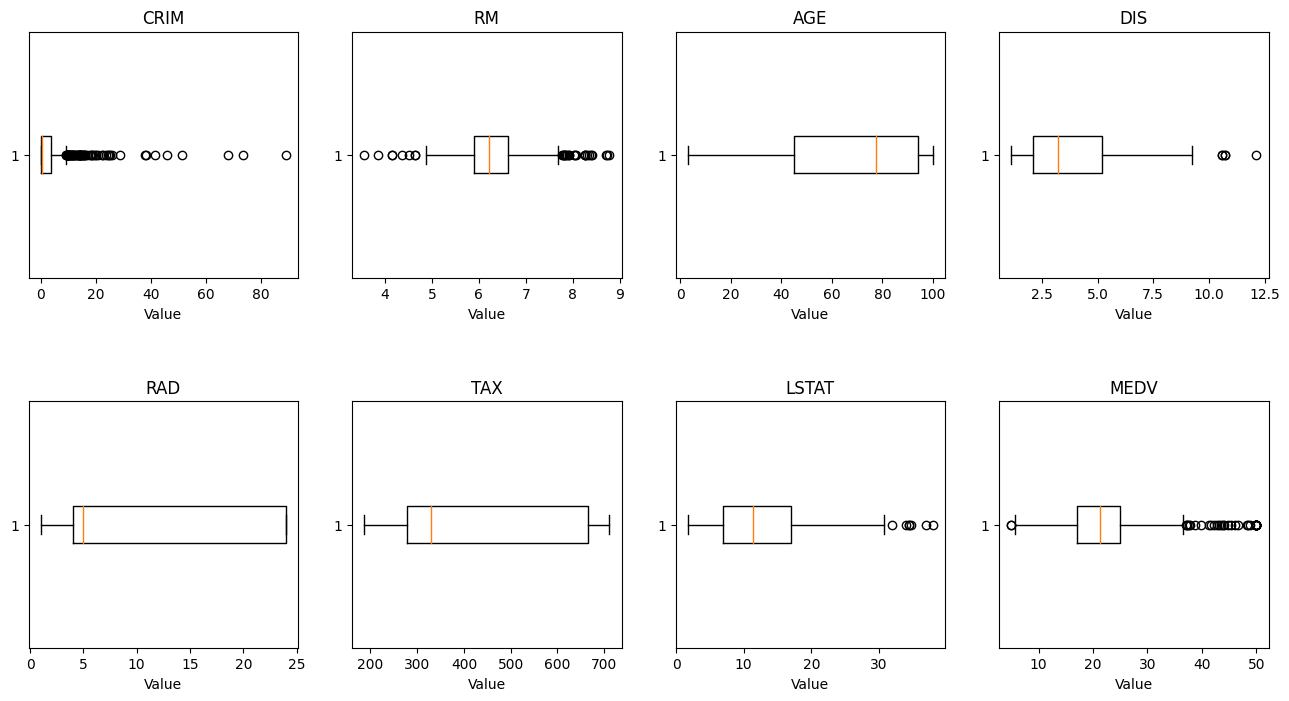

In [18]:
# Check for outliers
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Filter the DataFrame to select specific columns
selected_columns = ["CRIM", "RM", "AGE", "DIS", "RAD", "TAX", "LSTAT", "MEDV"]
filtered_df = df.select(selected_columns)

# Prepare data for plotting
data = [filtered_df.select(col).rdd.flatMap(lambda x: x).collect() for col in selected_columns]

# Create a box plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flatten()):
    ax.boxplot(data[i], vert=False)
    ax.set_title(selected_columns[i])
    ax.set_xlabel("Value")

plt.show()


### **8. Plot histogram Age10 column on a 2D Plot**

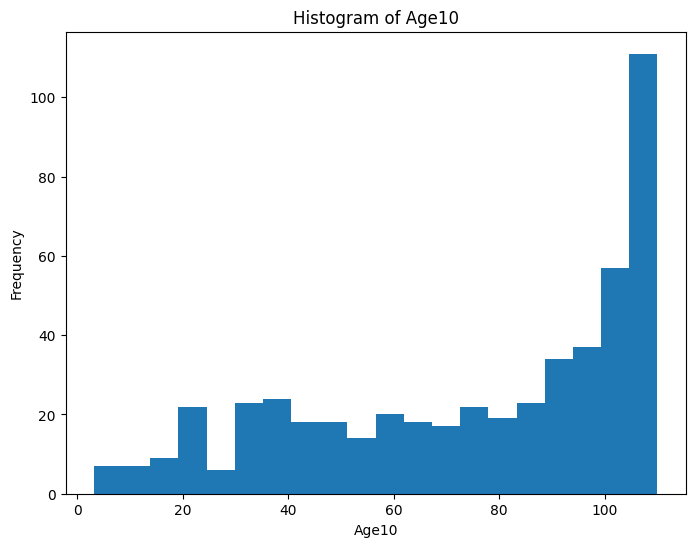

In [19]:
# Create a histogram for 'Age10'
import matplotlib.pyplot as plt

# Select the "rm" column
data = df.select("Age10").rdd.flatMap(lambda x: x).collect()

# Create a histogram for the 'Age10' column
plt.figure(figsize=(8, 6))
plt.hist(data, bins=20)
plt.xlabel("Age10")
plt.ylabel("Frequency")
plt.title("Histogram of Age10")
plt.show()

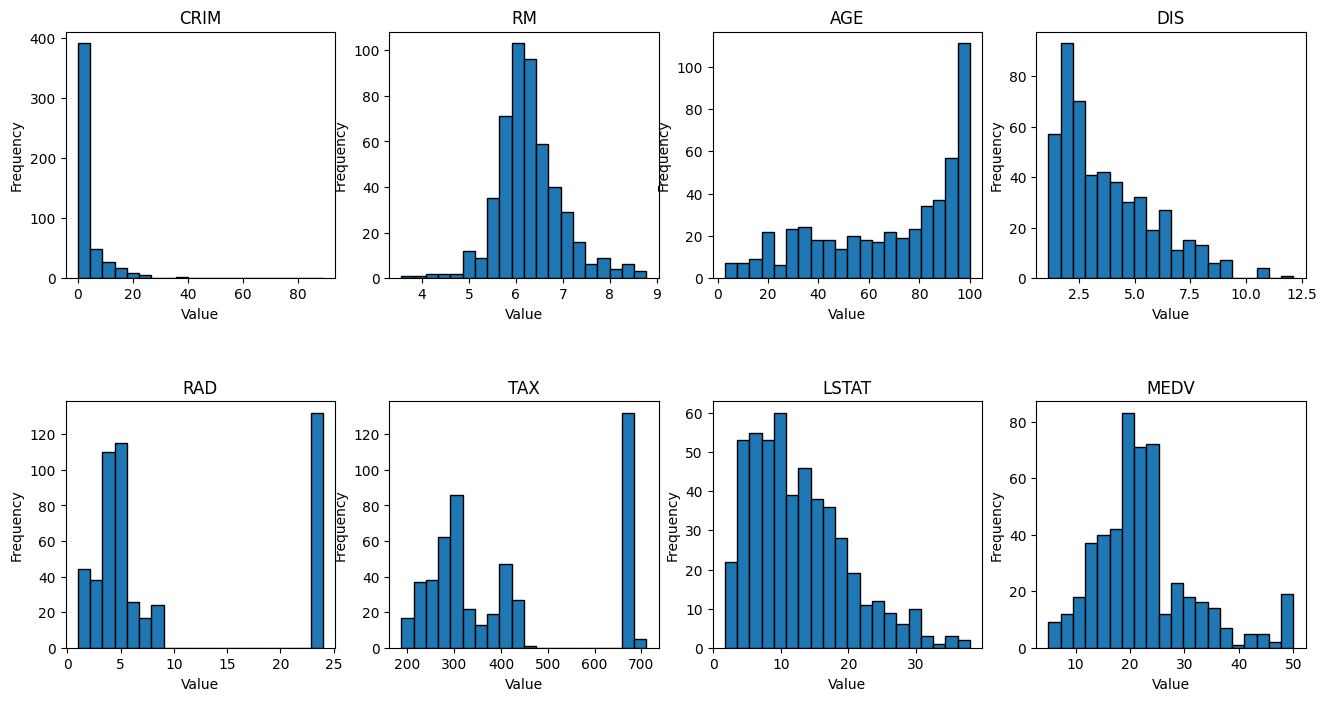

In [20]:
# Histograms

import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Filter the DataFrame to select specific columns
selected_columns = ["CRIM", "RM", "AGE", "DIS", "RAD", "TAX", "LSTAT", "MEDV"]
filtered_df = df.select(selected_columns)

# Create a list to store subplot axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

# Function to create distribution-like plots
def create_distribution_plot(ax, data, column_name):
    ax.hist(data, bins=20, edgecolor="k")
    ax.set_title(column_name)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Create distribution plots for each column
for i, column_name in enumerate(selected_columns):
    data = filtered_df.select(column_name).rdd.flatMap(lambda x: x).collect()
    create_distribution_plot(axes[i // 4, i % 4], data, column_name)

plt.show()


### **9. Provide Summary Statistics of all columns (count, mean, stddev,min, max)**

In [21]:
# Summary statistics for numeric columns
summary = df.describe()
summary.show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|               nox|                rm|               age|               dis|              rad|               tax|           ptratio|             lstat|              medv|             Age10|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|               506|               506|               506|               506|              

In [22]:
# Check for duplicate rows
unique_df = df.dropDuplicates()

# Compare counts
if df.count() != unique_df.count():
    print("Duplicate rows found.")
else:
    print("No duplicate rows.")

No duplicate rows.


In [23]:
# Check for missing values including NaN, blank, and null
from pyspark.sql.functions import isnan, isnull, when

missing_data = df.agg(*[
    F.sum(when(isnull(c) | isnan(c) | (F.col(c) == ""), 1).otherwise(0)).alias(c + "_NA")
    for c in df.columns
])

# Show the missing value counts for each column
missing_data.show()

+-------+-----+--------+-------+------+-----+------+------+------+------+----------+--------+-------+--------+
|crim_NA|zn_NA|indus_NA|chas_NA|nox_NA|rm_NA|age_NA|dis_NA|rad_NA|tax_NA|ptratio_NA|lstat_NA|medv_NA|Age10_NA|
+-------+-----+--------+-------+------+-----+------+------+------+------+----------+--------+-------+--------+
|      0|    0|       0|      0|     0|    0|     0|     0|     0|     0|         0|       0|      0|       0|
+-------+-----+--------+-------+------+-----+------+------+------+------+----------+--------+-------+--------+




### **10. Convert  Spark Dataframe to Pandas Dataframe**

In [24]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()


### **11. Show the last 5 rows of Pandas DataFrame**

In [25]:
# Show the last 5 rows of the Pandas DataFrame
pandas_df.tail(5)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,Age10
501,0.06,0.0,11.93,0,0.57,6.59,69.1,2.48,1,273,21.0,9.67,22.4,76.01
502,0.05,0.0,11.93,0,0.57,6.12,76.7,2.29,1,273,21.0,9.08,20.6,84.37
503,0.06,0.0,11.93,0,0.57,6.98,91.0,2.17,1,273,21.0,5.64,23.9,100.10
504,0.11,0.0,11.93,0,0.57,6.79,89.3,2.39,1,273,21.0,6.48,22.0,98.23
505,0.05,0.0,11.93,0,0.57,6.03,80.8,2.51,1,273,21.0,7.88,11.9,88.88


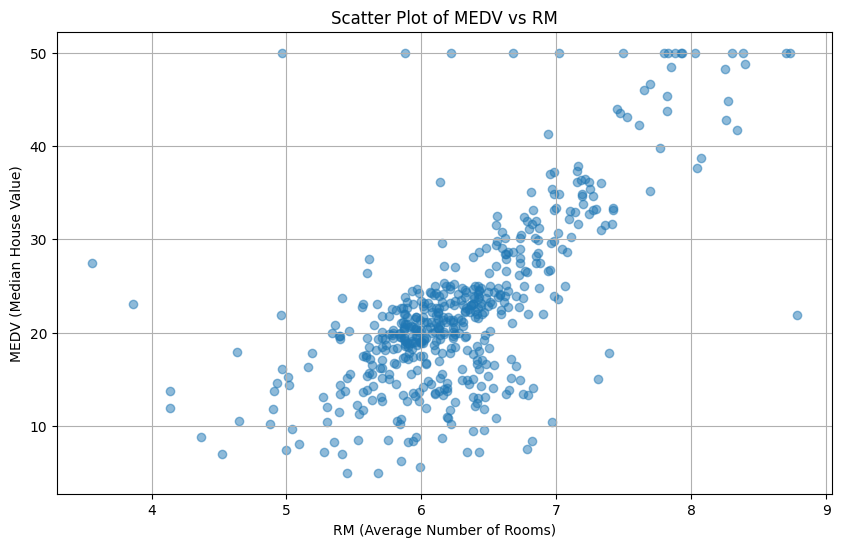

In [27]:
# Scatter Plot: RM vs MEDV
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["rm"], pandas_df["medv"], alpha=0.5)
plt.title("Scatter Plot of MEDV vs RM")
plt.xlabel("RM (Average Number of Rooms)")
plt.ylabel("MEDV (Median House Value)")
plt.grid(True)
plt.show()


In [29]:
sc.stop()

In [30]:
spark.sparkContext.stop()